### 1. Predict the chance of a pitch being put in play. Please use this model to predict the chance of each pitch in the “deploy.csv” file being put in play and return a csv with your predictions. 

I will start by importing the appropriate libraries.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

From there, load the training and deployment data into python. Do some quick inspection into the training data.

In [2]:
training = pd.read_csv('training.csv')
deploy = pd.read_csv('deploy.csv')

In [3]:
training.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


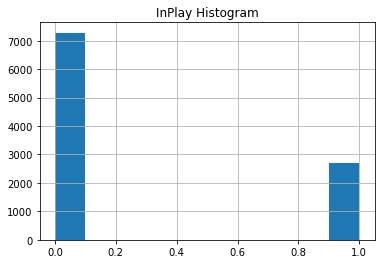

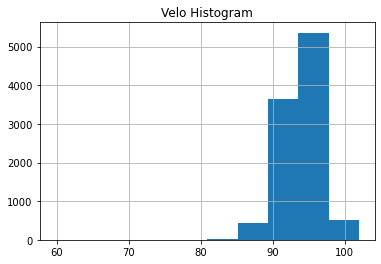

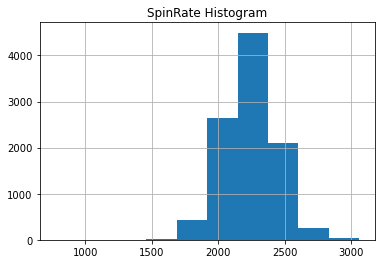

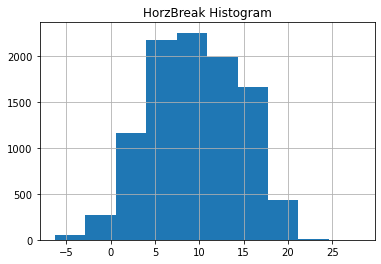

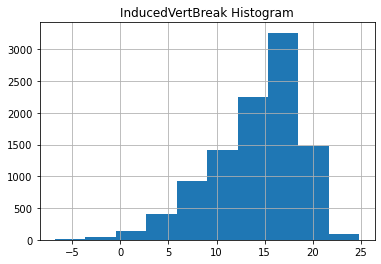

In [9]:
for key in training.keys():
    plt.figure()
    plt.title(f'{key} Histogram')
    training[key].hist()

In [10]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            10000 non-null  int64  
 1   Velo              10000 non-null  float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         10000 non-null  float64
 4   InducedVertBreak  10000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


The histograms of the data look fairly clean (no crazy skewed distributions) and the InPlay variable only takes on the values of 0 or 1. There are 6 null values in the SpinRate column which we will drop for simplicity.

In [12]:
training.dropna(inplace=True)

In [13]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            9994 non-null   int64  
 1   Velo              9994 non-null   float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         9994 non-null   float64
 4   InducedVertBreak  9994 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 468.5 KB


In [15]:
X = training.drop(columns = ['InPlay'])
y = training['InPlay']

In [16]:
X.head()

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,95.33,2893.0,10.68,21.33
1,94.41,2038.0,17.13,5.77
2,90.48,2183.0,6.61,15.39
3,93.04,2279.0,9.33,14.57
4,95.17,2384.0,6.99,17.62


In [17]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: InPlay, dtype: int64

Create the first model we will try which is a logistic regression.

In [22]:
model_log = LogisticRegression(random_state = 3).fit(X,y)

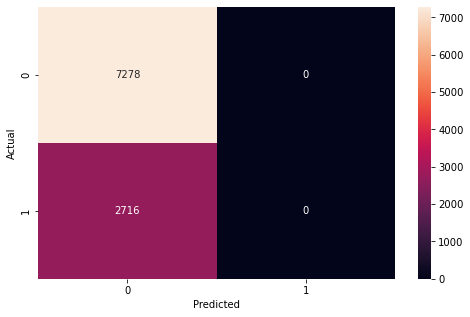

In [23]:
y_log = model_log.predict(X)

cm_log = confusion_matrix(y,y_log)

plt.figure(figsize = (8,5))
sns.heatmap(cm_log, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Interesting, the logistic regression predicted every single pitch would be not in play. Let's try a random forest classifier to see if we can make the results a bit better.

For the random forest classifier we want to avoid overfitting the model on all of the training data so we will use the train, test, split functionality to split the data into a training set and a test set. We will use 70% of the data to train the model and then reserve 30% of the data to test it. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

In [30]:
model_rf = RandomForestClassifier(random_state = 3).fit(X_train,y_train)

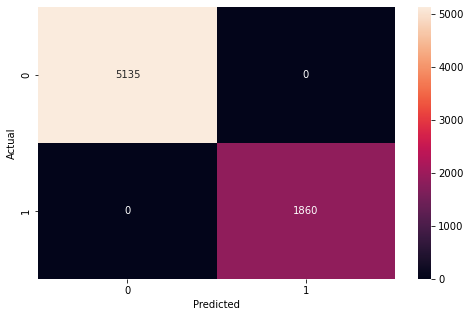

In [33]:
y_rf_train = model_rf.predict(X_train)

cm_rf_train = confusion_matrix(y_train,y_rf_train)

plt.figure(figsize = (8,5))
sns.heatmap(cm_rf_train, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

As you can see from the above confusion matrix, the model performs perfectly on the training data, this could be a sign of overfitting. We will check the performance on the testing data to determine how accurate the overall model is (at least for the given set of data).

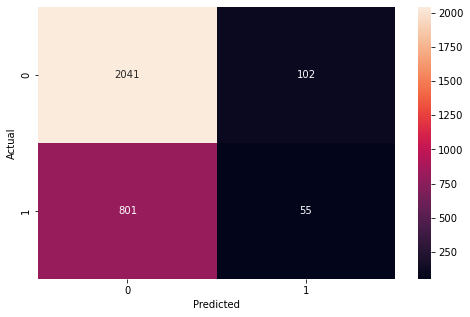

In [34]:
y_rf_test = model_rf.predict(X_test)

cm_rf_test = confusion_matrix(y_test,y_rf_test)

plt.figure(figsize = (8,5))
sns.heatmap(cm_rf_test, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
print(classification_report(y_test,y_rf_test))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      2143
           1       0.35      0.06      0.11       856

    accuracy                           0.70      2999
   macro avg       0.53      0.51      0.46      2999
weighted avg       0.61      0.70      0.62      2999



The model doesn't perform all that well on the testing data meaning it was likely overfit to the training data. Let's try one more go round with the random forest classifier but set the max depth to 2 to try to prevent overfitting.

In [37]:
model_rf2 = RandomForestClassifier(max_depth = 2, random_state = 3).fit(X_train,y_train)

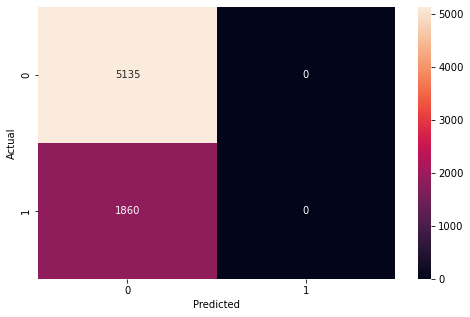

In [38]:
y_rf2_train = model_rf2.predict(X_train)

cm_rf2_train = confusion_matrix(y_train,y_rf2_train)

plt.figure(figsize = (8,5))
sns.heatmap(cm_rf2_train, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Changing the max depth to 2 reduces performance on the training set to that of the logisitic regression. Let's try to play with the max depth to balance overfitting. Once I reached a max depth of 20, the classifier still incorrectly classified some pitches, but overall performed very well. I'm hoping this model performs well on the testing data.

- The model does not perform that well on the testing data, classifying the majority of pitches as not in play. I will change the depth to 25 and see how that works.
- The model still doesn't perform great on the testing data but I'm not quite sure what to do from here. I know you can use hyperparameter tuning but unfortunately at this stage in my career in data science I'm not exactly sure what it does so I am uncomfortable using it in the assessment. 
- I am taking a machine learning class in my master's program next semester which should cover how to more robustly build a model to fit this type of data. 

- I will use the first Random Forest I created since it actually performed the best.

In [50]:
model_rf3 = RandomForestClassifier(max_depth = 25, random_state = 3).fit(X_train,y_train)

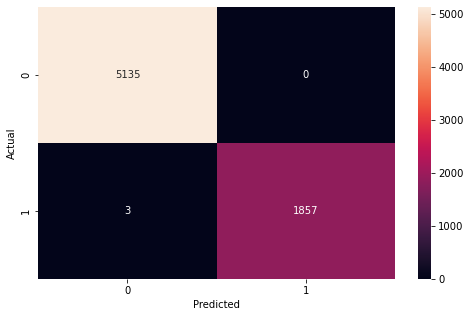

In [51]:
y_rf3_train = model_rf3.predict(X_train)

cm_rf3_train = confusion_matrix(y_train,y_rf3_train)

plt.figure(figsize = (8,5))
sns.heatmap(cm_rf3_train, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

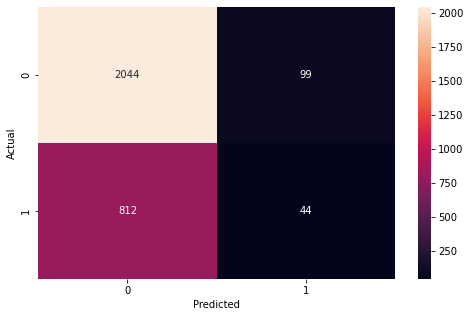

In [53]:
y_rf3_test = model_rf3.predict(X_test)

cm_rf3_test = confusion_matrix(y_test,y_rf3_test)

plt.figure(figsize = (8,5))
sns.heatmap(cm_rf3_test, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
deploy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Velo              10000 non-null  float64
 1   SpinRate          9987 non-null   float64
 2   HorzBreak         10000 non-null  float64
 3   InducedVertBreak  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB


In [56]:
deploy.dropna(inplace = True)

In [64]:
deploy_probs = model_rf.predict_proba(deploy)
in_play = deploy_probs[:,1]
deploy['InPlay'] = in_play

In [65]:
deploy.to_csv('deploy_probabilities.csv')

### 2. In one paragraph, please explain your process and reasoning for any decisions you made in Question 1.

In my code, there are snippets of my thought process and rationale as you step through, but here is a summary of the steps I took:
- I started out by attempting to use a logistic regression since that would be the most explainable model to a starting pitcher. Unfortunately, it predicted every pitch would not end up in play.
- From there, I went to a random forest classifier because you can still glean factor importance out of all the decision trees. The first model I created (and one I chose) performed extremely well on training data but didn't test as well. This is likely a sign of overfitting.
- The subsequent random forest models I created by modifying the max depth all performed worse on both the training and testing data than the initial model. As I outlined in my code, I am currently unsure of how to hyperparameter tune the random forest to make it perform better. In the next semester of my master's program I am taking a machine learning foundational course that I hope will help with this issue.

### 3. In one or two sentences, please describe to the pitcher how these 4 variables affect the batter’s ability to put the ball in play. You can also include one plot or table to show to the pitcher if you think it would help.

/Users/davidzack/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

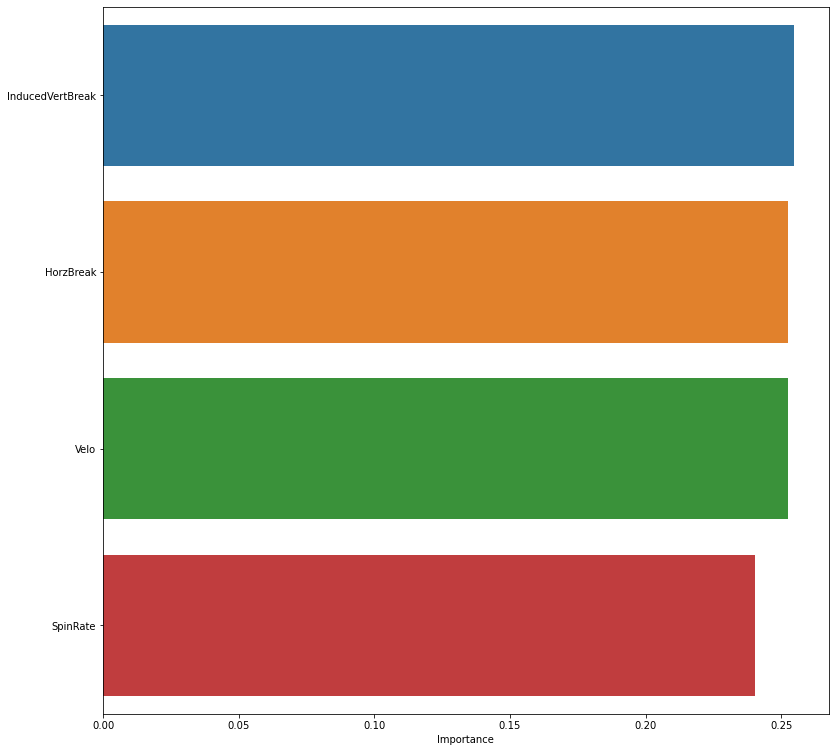

In [66]:
importances = model_rf.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance, importance_df.index)

Talking to the pitcher I would say the most important factors in determining whether or not a pitch will end up in play are induced vertical break, horizontal break, and velocity, in that order. They are all super close to each other, though, and should all be worked on in tandem. It is clear that spin rate is less important.

### 4. In one or two sentences, please describe what you would see as the next steps with your model and/or results if you were in the analyst role and had another week to work on the question posed by the pitcher.

I alluded to the next steps in my documentation of what steps I took, but the next steps I would take would be working with the R&D team to hyperparameter tune the random forest and make it more accurate. I would also further investigate how each factor listed positively or negatively impacted the chances of the ball winding up in play and report that back to the pitcher.